In [1]:
import torch
import random
import numpy as np
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_networkx
import scipy.sparse as sp
import networkx as nx
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
from tqdm import tqdm
import networkx as nx
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
import matplotlib.pyplot as plt 

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 1. familiarize yourself with the dataset （NOT MAIN PART)

In [3]:
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')
data = dataset[0]

edge_index = data.edge_index
print("edge_index.shape:", edge_index.shape)  # Directed edge count

adj = to_dense_adj(edge_index)[0]  # Adjacency matrix [N, N]
print("Adjacency matrix size:", adj.shape)
print("Non-zero elements in the adjacency matrix:", adj.sum().item())  # Directed edge count

# Count undirected edges
print(f"edge_index: {edge_index}")
print("Undirected edge count:", int(adj.sum().item() // 2))
print(adj)


edge_index.shape: torch.Size([2, 38])
Adjacency matrix size: torch.Size([17, 17])
Non-zero elements in the adjacency matrix: 38.0
edge_index: tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])
Undirected edge count: 19
tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
   

In [4]:
edge_index

tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
          8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
         15, 16],
        [ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
          7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
         14, 14]])

In [5]:
data.num_nodes

17

In [6]:
data.num_edges

38

# 2. generate  graph using E.R algorithm

## 2.1 write E.R. algorithm by hand


In [7]:
from collections import Counter
Counter(['a', 'b', 'a', 'c', 'b', 'a'])
# Output: Counter({'a': 3, 'b': 2, 'c': 1})

Counter({'a': 3, 'b': 2, 'c': 1})

In [8]:
train_dataset = dataset[:]
train_graphs_nx = [to_networkx(data, to_undirected=True) for data in train_dataset]

node_counts = []
density_dict = {}

for data in train_dataset:
    N = data.num_nodes
    E = data.num_edges // 2  
    node_counts.append(N)
    max_edges = N * (N - 1) / 2
    density = E / max_edges if max_edges > 0 else 0
    if N not in density_dict:
        density_dict[N] = []
    density_dict[N].append(density)

avg_density = {N: sum(dlist) / len(dlist) for N, dlist in density_dict.items()}
avg_density

{17: 0.13888888888888887,
 13: 0.17647058823529407,
 19: 0.12536549707602337,
 11: 0.2,
 28: 0.08553791887125221,
 16: 0.14374999999999996,
 20: 0.11804511278195487,
 12: 0.19114219114219114,
 22: 0.10735930735930736,
 18: 0.12745098039215685,
 23: 0.1049626701800615,
 27: 0.09401709401709402,
 24: 0.09057971014492754,
 14: 0.16012558869701726,
 15: 0.15918367346938775,
 26: 0.09107692307692308,
 21: 0.10773809523809523,
 25: 0.09444444444444444,
 10: 0.2222222222222222}

In [9]:
#node_counts
freq = Counter(node_counts)
freq
freq.keys()

dict_keys([17, 13, 19, 11, 28, 16, 20, 12, 22, 18, 23, 27, 24, 14, 15, 26, 21, 25, 10])

In [10]:
freq.values()

dict_values([18, 17, 16, 14, 3, 16, 14, 13, 15, 4, 18, 1, 4, 7, 7, 5, 8, 6, 2])

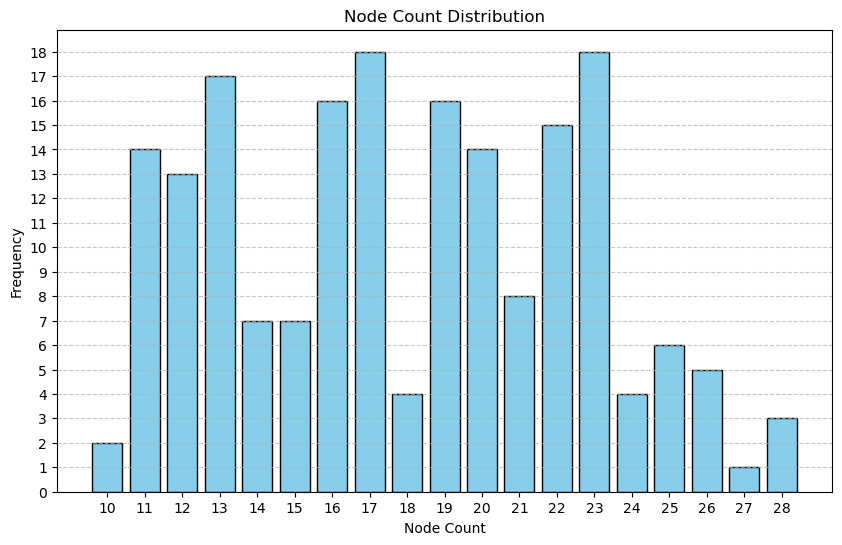

In [11]:

# Extract node counts and their frequencies
node_counts_values = list(freq.keys())
node_counts_frequencies = list(freq.values())

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(node_counts_values, node_counts_frequencies, color='skyblue', edgecolor='black')
plt.xlabel("Node Count")
plt.ylabel("Frequency")
plt.title("Node Count Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set x-axis ticks to integers
plt.xticks(range(min(node_counts_values), max(node_counts_values) + 1))
plt.yticks(range(0, max(node_counts_frequencies) +1))

plt.show()

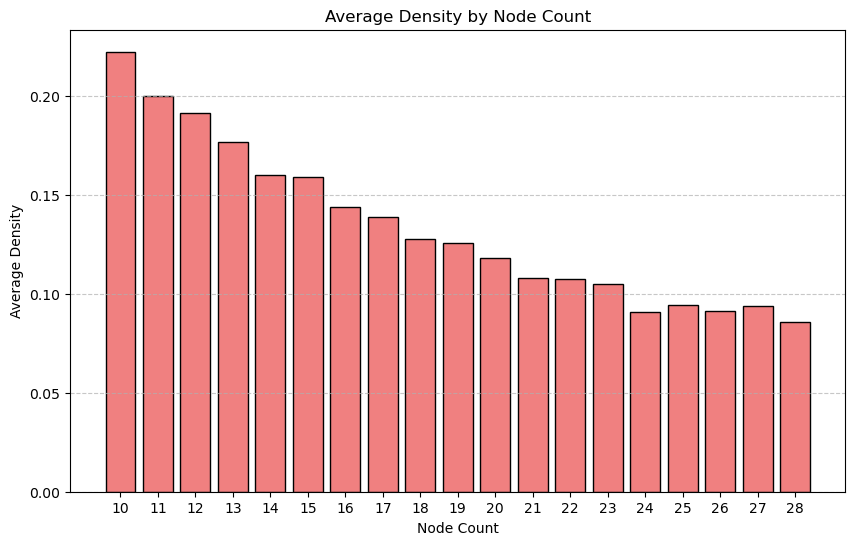

In [12]:
# Extract node counts and their corresponding average densities
node_counts = list(avg_density.keys())
densities = list(avg_density.values())

# Plot the density values
plt.figure(figsize=(10, 6))
plt.bar(node_counts, densities, color='lightcoral', edgecolor='black')
plt.xlabel("Node Count")
plt.ylabel("Average Density")
plt.title("Average Density by Node Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set x-axis ticks to integers
plt.xticks(range(min(node_counts), max(node_counts) +1))

plt.show()

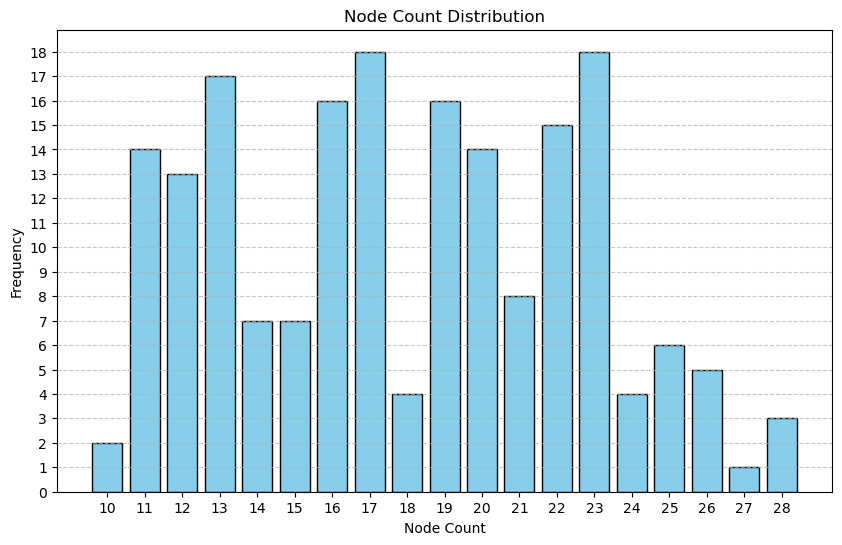

In [13]:
import matplotlib.pyplot as plt

# Extract node counts and their frequencies
node_counts_values = list(freq.keys())
node_counts_frequencies = list(freq.values())

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(node_counts_values, node_counts_frequencies, color='skyblue', edgecolor='black')
plt.xlabel("Node Count")
plt.ylabel("Frequency")
plt.title("Node Count Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set x-axis ticks to integers
plt.xticks(range(min(node_counts_values), max(node_counts_values) + 1))
plt.yticks(range(0, max(node_counts_frequencies) +1))

plt.show()

In [14]:
#sample N from empirical distribution
def sample_node_count():
    freq = Counter(node_counts)
    total = sum(freq.values())
    nodes = list(freq.keys())
    probs = [freq[n] / total for n in nodes]
    return np.random.choice(nodes, p=probs)

# generate Erdős-Rényi matrix
def ER_adj(N, p):
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            if p > np.random.uniform():
                A[i, j] = 1
                A[j, i] = 1
    return A

# generate Erdős-Rényi graph
def generate_erdos_renyi_graph():
    N = sample_node_count()
    r = avg_density[N]
    #print(f"N = {N}, r = {r}")
    adj = ER_adj(N, r)
    edge_index, _ = from_scipy_sparse_matrix(sp.csr_matrix(adj))
    x = torch.ones((N, 1))  # not important 
    return Data(x=x, edge_index=edge_index)

np.random.seed(42) #should not set it in the beginning
sampled_graphs = [generate_erdos_renyi_graph() for _ in range(1000)]
sampled_graphs_nx = [to_networkx(g, to_undirected=True) for g in sampled_graphs]

In [15]:
import pickle 

file_path = "baseline_samples.pkl"
with open(file_path, "wb") as f:
        pickle.dump(sampled_graphs_nx, f)

# 3. the unique and novel

## 3.1 novel unique

In [16]:
from collections import Counter
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash

train_hashes = []
for g in train_graphs_nx:
    train_hashes.append(weisfeiler_lehman_graph_hash(g,iterations=5))
# Generate hashes list of graphs + counter
sampled_hashes = [weisfeiler_lehman_graph_hash(g,iterations=5) for g in sampled_graphs_nx]
hash_counter = Counter(sampled_hashes)

# Novel: Not in the training set
novel_count = sum(1 for h in sampled_hashes if h not in train_hashes)
novel_percentage = novel_count / len(sampled_graphs_nx)

# Unique: Appears only once in the generated graphs
unique_count = sum(1 for h in sampled_hashes if hash_counter[h] == 1)
unique_percentage = unique_count / len(sampled_graphs_nx)

# Novel and Unique: Not in the training set and appears only once
novel_unique_count = sum(1 for h in sampled_hashes if h not in train_hashes and hash_counter[h] == 1)
novel_unique_percentage = novel_unique_count / len(sampled_graphs_nx)

# Output the three metrics
print("Novel:", novel_percentage)
print("Unique:", unique_percentage)
print("Novel and Unique:", novel_unique_percentage)

Novel: 1.0
Unique: 0.996
Novel and Unique: 0.996


# 4. comparison of distribution

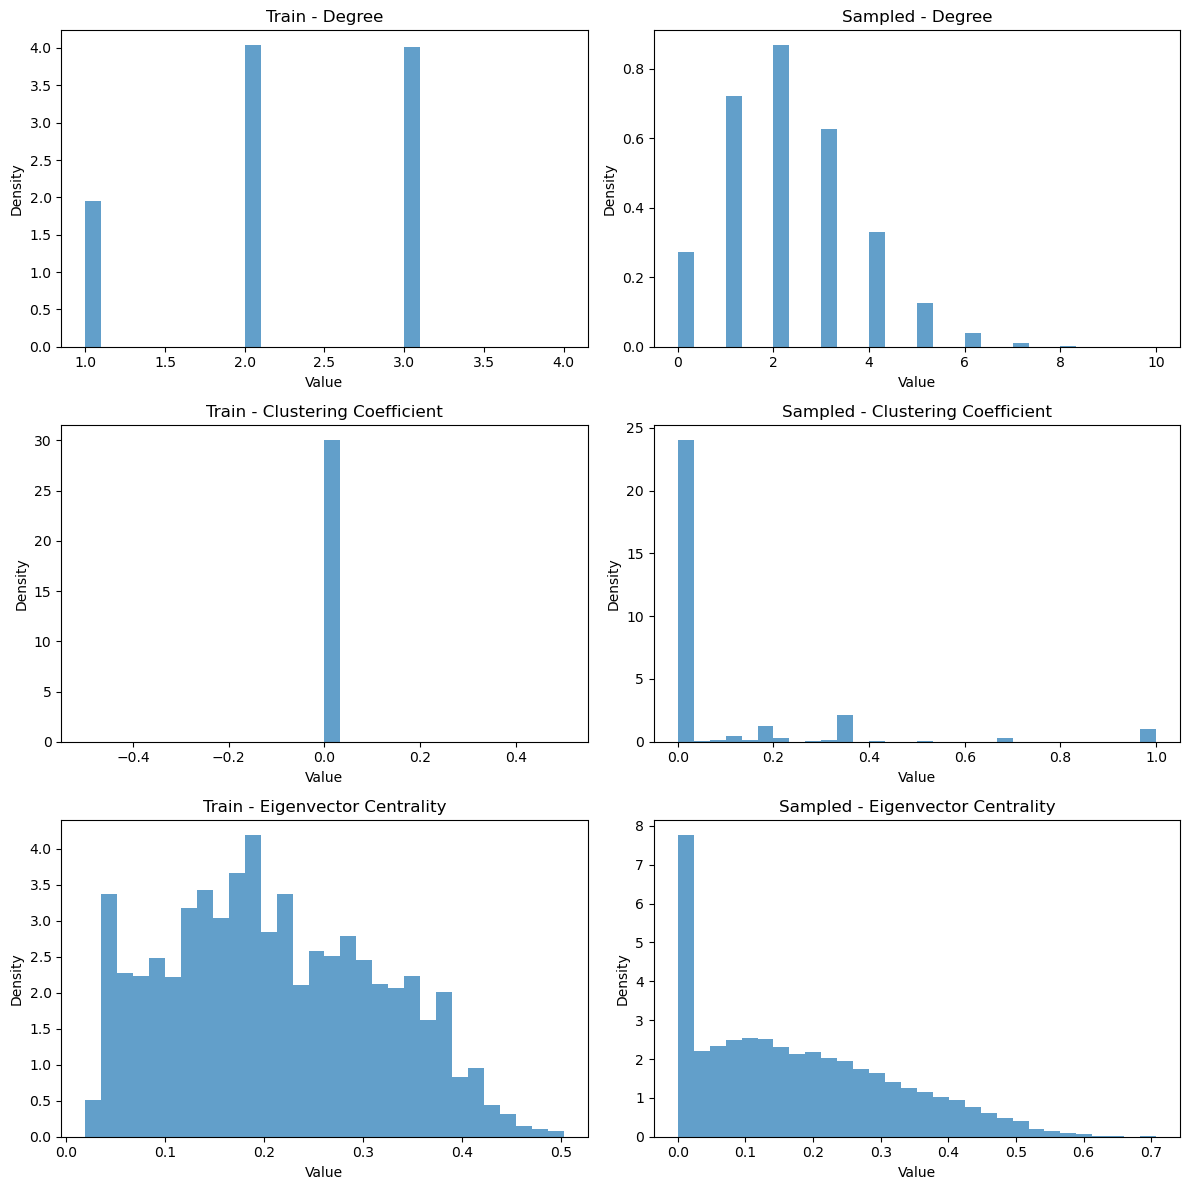

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import scipy.sparse as sp
from collections import Counter
from torch_geometric.utils import to_networkx, from_scipy_sparse_matrix
from torch_geometric.data import Data

#Statistical functions
def get_node_degrees(graphs):
    degrees = []
    for g in graphs:
        degrees.extend([d for _, d in g.degree()])
    return degrees

def get_clustering_coefficients(graphs):
    coeffs = []
    for g in graphs:
        coeffs.extend(list(nx.clustering(g).values()))
    return coeffs

def get_eigenvector_centrality_full(graphs):
    centralities = []
    for g in graphs:
        cen_full = {n: 0.0 for n in g.nodes()}
        if g.number_of_nodes() > 0:
            lcc_nodes = max(nx.connected_components(g), key=len)
            LCC = g.subgraph(lcc_nodes)
            cen_lcc = nx.eigenvector_centrality_numpy(LCC)
            cen_full.update(cen_lcc)
        centralities.extend(list(cen_full.values()))
    return centralities

#Extract statistics
train_degrees   = get_node_degrees(train_graphs_nx)
sampled_degrees = get_node_degrees(sampled_graphs_nx)

train_cluster   = get_clustering_coefficients(train_graphs_nx)
sampled_cluster = get_clustering_coefficients(sampled_graphs_nx)

train_eigen     = get_eigenvector_centrality_full(train_graphs_nx)
sampled_eigen   = get_eigenvector_centrality_full(sampled_graphs_nx)

#Plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
bins = 30

# First row: Degree
axes[0, 0].hist(train_degrees,   bins=bins, density=True, alpha=0.7)
axes[0, 0].set_title("Train - Degree")
axes[0, 1].hist(sampled_degrees, bins=bins, density=True, alpha=0.7)
axes[0, 1].set_title("Sampled - Degree")

# Second row: Clustering Coefficient
axes[1, 0].hist(train_cluster,   bins=bins, density=True, alpha=0.7)
axes[1, 0].set_title("Train - Clustering Coefficient")
axes[1, 1].hist(sampled_cluster, bins=bins, density=True, alpha=0.7)
axes[1, 1].set_title("Sampled - Clustering Coefficient")

# Third row: Eigenvector Centrality
axes[2, 0].hist(train_eigen,   bins=bins, density=True, alpha=0.7)
axes[2, 0].set_title("Train - Eigenvector Centrality")
axes[2, 1].hist(sampled_eigen, bins=bins, density=True, alpha=0.7)
axes[2, 1].set_title("Sampled - Eigenvector Centrality")

# Common labels
for ax in axes.flat:
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()